<a href="https://colab.research.google.com/github/Vikrampaswan07/cv/blob/main/Copy_of_CycleGAN_edited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd /content
!rm -rf Image-to-Sketch-using-Cycle-GAN
! git clone https://github.com/Harshpatel44/Image-to-Sketch-using-Cycle-GAN.git
%cd Image-to-Sketch-using-Cycle-GAN

/content
Cloning into 'Image-to-Sketch-using-Cycle-GAN'...
remote: Enumerating objects: 723, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 723 (delta 4), reused 0 (delta 0), pack-reused 714
Receiving objects: 100% (723/723), 245.82 MiB | 16.80 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/Image-to-Sketch-using-Cycle-GAN



## Load and Visualize the Data

In [2]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

In [3]:
def get_data_loader(image_type, image_dir='sketch2face', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size,128)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_type='face',batch_size=25)
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='sketch',batch_size=25)

## Display some Training Images


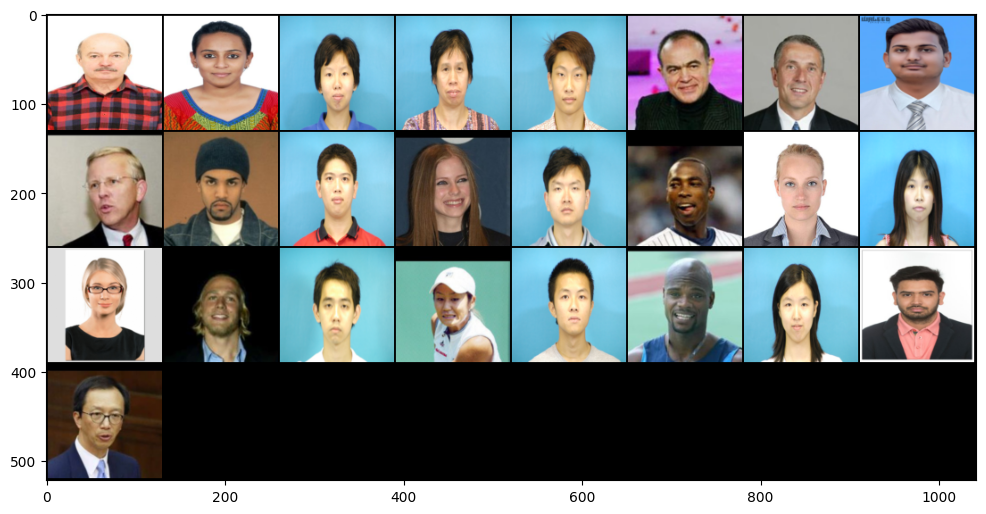

In [5]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

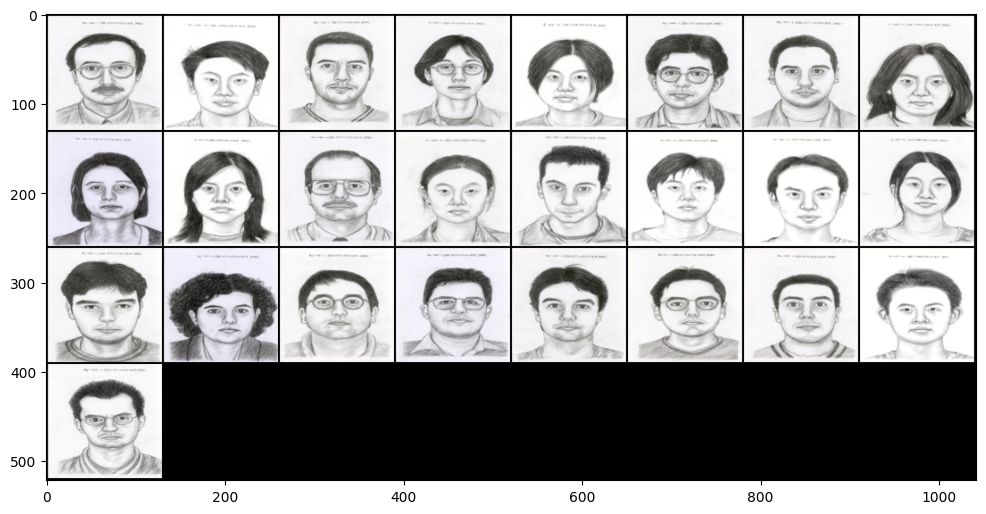

In [6]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = next(dataiter)

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.1255)
Max:  tensor(1.)


In [8]:
# helper scale function
def scale(x, feature_range=(-1, 1)):    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.7490)
Scaled max:  tensor(1.)


---
## Define the Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator


In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

Residual Block

In [12]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

In [13]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## The Generator 

In [14]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
Network

In [15]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [16]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

# pretrained weights will be used for further training and evaluating the model.
D_X.load_state_dict(torch.load('weights/D_X.pth'))
G_XtoY.load_state_dict(torch.load('weights/G_XtoY.pth'))
D_Y.load_state_dict(torch.load('weights/D_Y.pth'))
G_YtoX.load_state_dict(torch.load('weights/G_YtoX.pth'))

Models moved to GPU.


<All keys matched successfully>

---
### Loss Functions



In [17]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Optimizers


In [18]:
import torch.optim as optim

# hyperparams for Adam optimizer
#lr=0.0002
lr=0.00000001
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# function to save weights

In [19]:
def save_weights():
    torch.save(D_X.state_dict(),'weights/D_X.pth')
    torch.save(G_XtoY.state_dict(),'weights/G_XtoY.pth')
    torch.save(D_Y.state_dict(),'weights/D_Y.pth')
    torch.save(G_YtoX.state_dict(),'weights/G_YtoX.pth')    

---

## Training a CycleGAN

In [20]:
# import save code
from helpers import save_samples, checkpoint

In [21]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    for batch in test_dataloader_X:
      fixed_X = batch[0]
      break
    for batch in test_dataloader_Y:
      fixed_Y = batch[0]
      break
    #fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##
        # Train with real images
        d_x_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images  
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
        
        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()


        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images
        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=5)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=5)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=25)
            G_YtoX.train()
            G_XtoY.train()
            save_weights()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=10006
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses


In [22]:
n_epochs = 4000 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.0582 | d_Y_loss: 0.0369 | g_total_loss: 2.0858
Epoch [   20/ 4000] | d_X_loss: 0.0913 | d_Y_loss: 0.0353 | g_total_loss: 2.2523
Epoch [   30/ 4000] | d_X_loss: 0.0680 | d_Y_loss: 0.0304 | g_total_loss: 2.1443
Epoch [   40/ 4000] | d_X_loss: 0.0913 | d_Y_loss: 0.0435 | g_total_loss: 2.0439
Epoch [   50/ 4000] | d_X_loss: 0.0556 | d_Y_loss: 0.0449 | g_total_loss: 1.9766
Epoch [   60/ 4000] | d_X_loss: 0.0535 | d_Y_loss: 0.0482 | g_total_loss: 2.0310
Epoch [   70/ 4000] | d_X_loss: 0.0558 | d_Y_loss: 0.0476 | g_total_loss: 2.0918
Epoch [   80/ 4000] | d_X_loss: 0.1206 | d_Y_loss: 0.0252 | g_total_loss: 2.4226
Epoch [   90/ 4000] | d_X_loss: 0.0882 | d_Y_loss: 0.0347 | g_total_loss: 1.9936


Epoch [  100/ 4000] | d_X_loss: 0.1046 | d_Y_loss: 0.0469 | g_total_loss: 2.0235


Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  110/ 4000] | d_X_loss: 0.0682 | d_Y_loss: 0.0352 | g_total_loss: 2.1175
Epoch [  120/ 4000] | d_X_loss: 0.1177 | d_Y_loss: 0.0290 | g_total_loss: 2.1643
Epoch [  130/ 4000] | d_X_loss: 0.0684 | d_Y_loss: 0.0504 | g_total_loss: 2.0008
Epoch [  140/ 4000] | d_X_loss: 0.1209 | d_Y_loss: 0.0297 | g_total_loss: 2.0934
Epoch [  150/ 4000] | d_X_loss: 0.0509 | d_Y_loss: 0.0358 | g_total_loss: 2.1489
Epoch [  160/ 4000] | d_X_loss: 0.0949 | d_Y_loss: 0.0356 | g_total_loss: 2.2880
Epoch [  170/ 4000] | d_X_loss: 0.2028 | d_Y_loss: 0.0346 | g_total_loss: 2.5204
Epoch [  180/ 4000] | d_X_loss: 0.0627 | d_Y_loss: 0.0465 | g_total_loss: 2.0590
Epoch [  190/ 4000] | d_X_loss: 0.0704 | d_Y_loss: 0.0413 | g_total_loss: 2.1570


Epoch [  200/ 4000] | d_X_loss: 0.1183 | d_Y_loss: 0.0418 | g_total_loss: 1.9560


Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  210/ 4000] | d_X_loss: 0.0540 | d_Y_loss: 0.0320 | g_total_loss: 2.2402
Epoch [  220/ 4000] | d_X_loss: 0.0593 | d_Y_loss: 0.0501 | g_total_loss: 2.0997
Epoch [  230/ 4000] | d_X_loss: 0.0459 | d_Y_loss: 0.0237 | g_total_loss: 2.2358
Epoch [  240/ 4000] | d_X_loss: 0.1039 | d_Y_loss: 0.0274 | g_total_loss: 2.1562
Epoch [  250/ 4000] | d_X_loss: 0.0509 | d_Y_loss: 0.0302 | g_total_loss: 2.1828
Epoch [  260/ 4000] | d_X_loss: 0.1807 | d_Y_loss: 0.0419 | g_total_loss: 2.2085
Epoch [  270/ 4000] | d_X_loss: 0.0660 | d_Y_loss: 0.0270 | g_total_loss: 2.2387
Epoch [  280/ 4000] | d_X_loss: 0.0500 | d_Y_loss: 0.0496 | g_total_loss: 2.1355
Epoch [  290/ 4000] | d_X_loss: 0.0672 | d_Y_loss: 0.0471 | g_total_loss: 2.0469


Epoch [  300/ 4000] | d_X_loss: 0.0807 | d_Y_loss: 0.0385 | g_total_loss: 1.9920


Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  310/ 4000] | d_X_loss: 0.0686 | d_Y_loss: 0.0438 | g_total_loss: 1.9330
Epoch [  320/ 4000] | d_X_loss: 0.0658 | d_Y_loss: 0.0299 | g_total_loss: 2.1291
Epoch [  330/ 4000] | d_X_loss: 0.0651 | d_Y_loss: 0.0338 | g_total_loss: 2.0682
Epoch [  340/ 4000] | d_X_loss: 0.1005 | d_Y_loss: 0.0419 | g_total_loss: 2.0004
Epoch [  350/ 4000] | d_X_loss: 0.0903 | d_Y_loss: 0.0203 | g_total_loss: 2.2190
Epoch [  360/ 4000] | d_X_loss: 0.0804 | d_Y_loss: 0.0367 | g_total_loss: 2.1969
Epoch [  370/ 4000] | d_X_loss: 0.1234 | d_Y_loss: 0.0554 | g_total_loss: 1.9666
Epoch [  380/ 4000] | d_X_loss: 0.0633 | d_Y_loss: 0.0419 | g_total_loss: 1.9996
Epoch [  390/ 4000] | d_X_loss: 0.1533 | d_Y_loss: 0.0389 | g_total_loss: 1.9716


Epoch [  400/ 4000] | d_X_loss: 0.0984 | d_Y_loss: 0.0383 | g_total_loss: 2.0074


Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  410/ 4000] | d_X_loss: 0.0508 | d_Y_loss: 0.0472 | g_total_loss: 2.2558
Epoch [  420/ 4000] | d_X_loss: 0.0603 | d_Y_loss: 0.0506 | g_total_loss: 2.0604
Epoch [  430/ 4000] | d_X_loss: 0.0977 | d_Y_loss: 0.0325 | g_total_loss: 2.2409
Epoch [  440/ 4000] | d_X_loss: 0.0996 | d_Y_loss: 0.0118 | g_total_loss: 2.6830
Epoch [  450/ 4000] | d_X_loss: 0.0632 | d_Y_loss: 0.0298 | g_total_loss: 2.2308
Epoch [  460/ 4000] | d_X_loss: 0.0586 | d_Y_loss: 0.0414 | g_total_loss: 2.0503
Epoch [  470/ 4000] | d_X_loss: 0.0862 | d_Y_loss: 0.0415 | g_total_loss: 2.1082
Epoch [  480/ 4000] | d_X_loss: 0.0619 | d_Y_loss: 0.0441 | g_total_loss: 2.1207
Epoch [  490/ 4000] | d_X_loss: 0.0478 | d_Y_loss: 0.0215 | g_total_loss: 2.2585


Epoch [  500/ 4000] | d_X_loss: 0.0780 | d_Y_loss: 0.0293 | g_total_loss: 2.1760


Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  510/ 4000] | d_X_loss: 0.0819 | d_Y_loss: 0.0324 | g_total_loss: 2.1737
Epoch [  520/ 4000] | d_X_loss: 0.0656 | d_Y_loss: 0.0263 | g_total_loss: 2.1030
Epoch [  530/ 4000] | d_X_loss: 0.1184 | d_Y_loss: 0.0332 | g_total_loss: 2.2240
Epoch [  540/ 4000] | d_X_loss: 0.0449 | d_Y_loss: 0.0344 | g_total_loss: 2.1493
Epoch [  550/ 4000] | d_X_loss: 0.1015 | d_Y_loss: 0.0286 | g_total_loss: 2.0724
Epoch [  560/ 4000] | d_X_loss: 0.1031 | d_Y_loss: 0.0290 | g_total_loss: 2.0596
Epoch [  570/ 4000] | d_X_loss: 0.0584 | d_Y_loss: 0.0417 | g_total_loss: 2.1341
Epoch [  580/ 4000] | d_X_loss: 0.0925 | d_Y_loss: 0.0263 | g_total_loss: 2.1664
Epoch [  590/ 4000] | d_X_loss: 0.0641 | d_Y_loss: 0.0330 | g_total_loss: 2.0728


Epoch [  600/ 4000] | d_X_loss: 0.0698 | d_Y_loss: 0.0341 | g_total_loss: 2.2791


Saved samples_cyclegan/sample-000600-X-Y.png
Saved samples_cyclegan/sample-000600-Y-X.png
Epoch [  610/ 4000] | d_X_loss: 0.0817 | d_Y_loss: 0.0310 | g_total_loss: 2.0102
Epoch [  620/ 4000] | d_X_loss: 0.1549 | d_Y_loss: 0.0415 | g_total_loss: 2.1055
Epoch [  630/ 4000] | d_X_loss: 0.0539 | d_Y_loss: 0.0264 | g_total_loss: 2.1986
Epoch [  640/ 4000] | d_X_loss: 0.0782 | d_Y_loss: 0.0469 | g_total_loss: 2.1079
Epoch [  650/ 4000] | d_X_loss: 0.0545 | d_Y_loss: 0.0416 | g_total_loss: 2.0373
Epoch [  660/ 4000] | d_X_loss: 0.0776 | d_Y_loss: 0.0368 | g_total_loss: 2.1013
Epoch [  670/ 4000] | d_X_loss: 0.0534 | d_Y_loss: 0.0312 | g_total_loss: 2.1205
Epoch [  680/ 4000] | d_X_loss: 0.0568 | d_Y_loss: 0.0227 | g_total_loss: 2.1746
Epoch [  690/ 4000] | d_X_loss: 0.0806 | d_Y_loss: 0.0356 | g_total_loss: 2.1147


Epoch [  700/ 4000] | d_X_loss: 0.0544 | d_Y_loss: 0.0364 | g_total_loss: 2.1566


Saved samples_cyclegan/sample-000700-X-Y.png
Saved samples_cyclegan/sample-000700-Y-X.png
Epoch [  710/ 4000] | d_X_loss: 0.0570 | d_Y_loss: 0.1193 | g_total_loss: 3.3166
Epoch [  720/ 4000] | d_X_loss: 0.1163 | d_Y_loss: 0.0339 | g_total_loss: 2.1772
Epoch [  730/ 4000] | d_X_loss: 0.0631 | d_Y_loss: 0.0382 | g_total_loss: 2.0632
Epoch [  740/ 4000] | d_X_loss: 0.0484 | d_Y_loss: 0.0364 | g_total_loss: 2.1811
Epoch [  750/ 4000] | d_X_loss: 0.0588 | d_Y_loss: 0.0371 | g_total_loss: 2.1002
Epoch [  760/ 4000] | d_X_loss: 0.0628 | d_Y_loss: 0.0433 | g_total_loss: 2.0463
Epoch [  770/ 4000] | d_X_loss: 0.0658 | d_Y_loss: 0.0394 | g_total_loss: 2.0796
Epoch [  780/ 4000] | d_X_loss: 0.0448 | d_Y_loss: 0.0286 | g_total_loss: 2.2711
Epoch [  790/ 4000] | d_X_loss: 0.0738 | d_Y_loss: 0.0500 | g_total_loss: 2.0028


Epoch [  800/ 4000] | d_X_loss: 0.0878 | d_Y_loss: 0.0276 | g_total_loss: 2.2390


Saved samples_cyclegan/sample-000800-X-Y.png
Saved samples_cyclegan/sample-000800-Y-X.png
Epoch [  810/ 4000] | d_X_loss: 0.0687 | d_Y_loss: 0.0347 | g_total_loss: 2.0743
Epoch [  820/ 4000] | d_X_loss: 0.0488 | d_Y_loss: 0.0417 | g_total_loss: 2.1157
Epoch [  830/ 4000] | d_X_loss: 0.1568 | d_Y_loss: 0.0372 | g_total_loss: 2.1088
Epoch [  840/ 4000] | d_X_loss: 0.0832 | d_Y_loss: 0.0288 | g_total_loss: 2.1249
Epoch [  850/ 4000] | d_X_loss: 0.1316 | d_Y_loss: 0.0254 | g_total_loss: 2.2691
Epoch [  860/ 4000] | d_X_loss: 0.0621 | d_Y_loss: 0.0304 | g_total_loss: 2.1605
Epoch [  870/ 4000] | d_X_loss: 0.0640 | d_Y_loss: 0.0313 | g_total_loss: 2.2020
Epoch [  880/ 4000] | d_X_loss: 0.0596 | d_Y_loss: 0.0276 | g_total_loss: 2.0735
Epoch [  890/ 4000] | d_X_loss: 0.0889 | d_Y_loss: 0.0338 | g_total_loss: 2.4646


Epoch [  900/ 4000] | d_X_loss: 0.0672 | d_Y_loss: 0.0382 | g_total_loss: 2.0685


Saved samples_cyclegan/sample-000900-X-Y.png
Saved samples_cyclegan/sample-000900-Y-X.png
Epoch [  910/ 4000] | d_X_loss: 0.0797 | d_Y_loss: 0.0348 | g_total_loss: 2.1210
Epoch [  920/ 4000] | d_X_loss: 0.0472 | d_Y_loss: 0.0402 | g_total_loss: 2.0608
Epoch [  930/ 4000] | d_X_loss: 0.0851 | d_Y_loss: 0.0371 | g_total_loss: 2.0873
Epoch [  940/ 4000] | d_X_loss: 0.0624 | d_Y_loss: 0.0356 | g_total_loss: 2.1199
Epoch [  950/ 4000] | d_X_loss: 0.0442 | d_Y_loss: 0.0313 | g_total_loss: 2.1400
Epoch [  960/ 4000] | d_X_loss: 0.0632 | d_Y_loss: 0.0329 | g_total_loss: 2.0237
Epoch [  970/ 4000] | d_X_loss: 0.0754 | d_Y_loss: 0.0265 | g_total_loss: 2.1567
Epoch [  980/ 4000] | d_X_loss: 0.1709 | d_Y_loss: 0.0284 | g_total_loss: 2.2158
Epoch [  990/ 4000] | d_X_loss: 0.0495 | d_Y_loss: 0.0448 | g_total_loss: 2.1925


Epoch [ 1000/ 4000] | d_X_loss: 0.0465 | d_Y_loss: 0.0293 | g_total_loss: 2.1813


Saved samples_cyclegan/sample-001000-X-Y.png
Saved samples_cyclegan/sample-001000-Y-X.png
Epoch [ 1010/ 4000] | d_X_loss: 0.0568 | d_Y_loss: 0.0258 | g_total_loss: 2.1375
Epoch [ 1020/ 4000] | d_X_loss: 0.0540 | d_Y_loss: 0.0278 | g_total_loss: 2.2208
Epoch [ 1030/ 4000] | d_X_loss: 0.0691 | d_Y_loss: 0.0220 | g_total_loss: 2.2500
Epoch [ 1040/ 4000] | d_X_loss: 0.0899 | d_Y_loss: 0.0382 | g_total_loss: 2.1320
Epoch [ 1050/ 4000] | d_X_loss: 0.0628 | d_Y_loss: 0.0290 | g_total_loss: 2.3052
Epoch [ 1060/ 4000] | d_X_loss: 0.0779 | d_Y_loss: 0.0480 | g_total_loss: 2.1136
Epoch [ 1070/ 4000] | d_X_loss: 0.1251 | d_Y_loss: 0.0474 | g_total_loss: 2.0181
Epoch [ 1080/ 4000] | d_X_loss: 0.0808 | d_Y_loss: 0.0345 | g_total_loss: 2.1634
Epoch [ 1090/ 4000] | d_X_loss: 0.0432 | d_Y_loss: 0.0328 | g_total_loss: 2.1583


Epoch [ 1100/ 4000] | d_X_loss: 0.0697 | d_Y_loss: 0.0387 | g_total_loss: 2.1470


Saved samples_cyclegan/sample-001100-X-Y.png
Saved samples_cyclegan/sample-001100-Y-X.png
Epoch [ 1110/ 4000] | d_X_loss: 0.0568 | d_Y_loss: 0.0360 | g_total_loss: 2.0715
Epoch [ 1120/ 4000] | d_X_loss: 0.0667 | d_Y_loss: 0.0372 | g_total_loss: 2.0229
Epoch [ 1130/ 4000] | d_X_loss: 0.0512 | d_Y_loss: 0.0238 | g_total_loss: 2.2375
Epoch [ 1140/ 4000] | d_X_loss: 0.0756 | d_Y_loss: 0.0493 | g_total_loss: 2.1925
Epoch [ 1150/ 4000] | d_X_loss: 0.0838 | d_Y_loss: 0.0280 | g_total_loss: 2.3072
Epoch [ 1160/ 4000] | d_X_loss: 0.1292 | d_Y_loss: 0.0355 | g_total_loss: 2.0973
Epoch [ 1170/ 4000] | d_X_loss: 0.0810 | d_Y_loss: 0.0342 | g_total_loss: 2.0638
Epoch [ 1180/ 4000] | d_X_loss: 0.0576 | d_Y_loss: 0.0335 | g_total_loss: 2.1168
Epoch [ 1190/ 4000] | d_X_loss: 0.0824 | d_Y_loss: 0.0324 | g_total_loss: 2.0497


Epoch [ 1200/ 4000] | d_X_loss: 0.0413 | d_Y_loss: 0.0299 | g_total_loss: 2.1774


Saved samples_cyclegan/sample-001200-X-Y.png
Saved samples_cyclegan/sample-001200-Y-X.png
Epoch [ 1210/ 4000] | d_X_loss: 0.0530 | d_Y_loss: 0.0309 | g_total_loss: 2.1438
Epoch [ 1220/ 4000] | d_X_loss: 0.0851 | d_Y_loss: 0.0363 | g_total_loss: 2.0430
Epoch [ 1230/ 4000] | d_X_loss: 0.0448 | d_Y_loss: 0.0457 | g_total_loss: 2.0995
Epoch [ 1240/ 4000] | d_X_loss: 0.0636 | d_Y_loss: 0.0357 | g_total_loss: 2.0473
Epoch [ 1250/ 4000] | d_X_loss: 0.1403 | d_Y_loss: 0.0298 | g_total_loss: 2.5166
Epoch [ 1260/ 4000] | d_X_loss: 0.0541 | d_Y_loss: 0.0382 | g_total_loss: 2.1282
Epoch [ 1270/ 4000] | d_X_loss: 0.0517 | d_Y_loss: 0.0320 | g_total_loss: 2.1937
Epoch [ 1280/ 4000] | d_X_loss: 0.0573 | d_Y_loss: 0.0295 | g_total_loss: 2.2437
Epoch [ 1290/ 4000] | d_X_loss: 0.0773 | d_Y_loss: 0.0431 | g_total_loss: 2.0198


Epoch [ 1300/ 4000] | d_X_loss: 0.0911 | d_Y_loss: 0.0357 | g_total_loss: 2.0505


Saved samples_cyclegan/sample-001300-X-Y.png
Saved samples_cyclegan/sample-001300-Y-X.png
Epoch [ 1310/ 4000] | d_X_loss: 0.0732 | d_Y_loss: 0.0329 | g_total_loss: 1.9947
Epoch [ 1320/ 4000] | d_X_loss: 0.0642 | d_Y_loss: 0.0355 | g_total_loss: 2.0617
Epoch [ 1330/ 4000] | d_X_loss: 0.1016 | d_Y_loss: 0.0297 | g_total_loss: 2.1235
Epoch [ 1340/ 4000] | d_X_loss: 0.1259 | d_Y_loss: 0.0283 | g_total_loss: 2.4706
Epoch [ 1350/ 4000] | d_X_loss: 0.0766 | d_Y_loss: 0.0340 | g_total_loss: 2.0564
Epoch [ 1360/ 4000] | d_X_loss: 0.0843 | d_Y_loss: 0.0502 | g_total_loss: 2.0927
Epoch [ 1370/ 4000] | d_X_loss: 0.0929 | d_Y_loss: 0.0331 | g_total_loss: 2.1238
Epoch [ 1380/ 4000] | d_X_loss: 0.1409 | d_Y_loss: 0.0499 | g_total_loss: 1.9814
Epoch [ 1390/ 4000] | d_X_loss: 0.0481 | d_Y_loss: 0.0317 | g_total_loss: 2.1722


Epoch [ 1400/ 4000] | d_X_loss: 0.0782 | d_Y_loss: 0.0338 | g_total_loss: 2.0883


Saved samples_cyclegan/sample-001400-X-Y.png
Saved samples_cyclegan/sample-001400-Y-X.png
Epoch [ 1410/ 4000] | d_X_loss: 0.1094 | d_Y_loss: 0.0341 | g_total_loss: 2.1650
Epoch [ 1420/ 4000] | d_X_loss: 0.1337 | d_Y_loss: 0.0460 | g_total_loss: 1.9472
Epoch [ 1430/ 4000] | d_X_loss: 0.1174 | d_Y_loss: 0.0302 | g_total_loss: 2.2889
Epoch [ 1440/ 4000] | d_X_loss: 0.0601 | d_Y_loss: 0.0402 | g_total_loss: 2.0321
Epoch [ 1450/ 4000] | d_X_loss: 0.0544 | d_Y_loss: 0.0391 | g_total_loss: 2.0978
Epoch [ 1460/ 4000] | d_X_loss: 0.0753 | d_Y_loss: 0.0230 | g_total_loss: 2.1863
Epoch [ 1470/ 4000] | d_X_loss: 0.1429 | d_Y_loss: 0.0318 | g_total_loss: 2.0147
Epoch [ 1480/ 4000] | d_X_loss: 0.0585 | d_Y_loss: 0.0467 | g_total_loss: 2.3550
Epoch [ 1490/ 4000] | d_X_loss: 0.0537 | d_Y_loss: 0.0229 | g_total_loss: 2.4147


Epoch [ 1500/ 4000] | d_X_loss: 0.0529 | d_Y_loss: 0.0151 | g_total_loss: 2.2395


Saved samples_cyclegan/sample-001500-X-Y.png
Saved samples_cyclegan/sample-001500-Y-X.png
Epoch [ 1510/ 4000] | d_X_loss: 0.0683 | d_Y_loss: 0.0295 | g_total_loss: 2.1378
Epoch [ 1520/ 4000] | d_X_loss: 0.0520 | d_Y_loss: 0.0330 | g_total_loss: 2.1586
Epoch [ 1530/ 4000] | d_X_loss: 0.0651 | d_Y_loss: 0.0208 | g_total_loss: 2.1980
Epoch [ 1540/ 4000] | d_X_loss: 0.1048 | d_Y_loss: 0.0299 | g_total_loss: 2.1361
Epoch [ 1550/ 4000] | d_X_loss: 0.0950 | d_Y_loss: 0.0461 | g_total_loss: 1.9895
Epoch [ 1560/ 4000] | d_X_loss: 0.0814 | d_Y_loss: 0.0321 | g_total_loss: 2.0453
Epoch [ 1570/ 4000] | d_X_loss: 0.0781 | d_Y_loss: 0.0353 | g_total_loss: 2.1101
Epoch [ 1580/ 4000] | d_X_loss: 0.1454 | d_Y_loss: 0.0299 | g_total_loss: 2.1049
Epoch [ 1590/ 4000] | d_X_loss: 0.1240 | d_Y_loss: 0.0321 | g_total_loss: 2.0582


Epoch [ 1600/ 4000] | d_X_loss: 0.0979 | d_Y_loss: 0.0497 | g_total_loss: 1.9415


Saved samples_cyclegan/sample-001600-X-Y.png
Saved samples_cyclegan/sample-001600-Y-X.png
Epoch [ 1610/ 4000] | d_X_loss: 0.0494 | d_Y_loss: 0.0279 | g_total_loss: 2.2537
Epoch [ 1620/ 4000] | d_X_loss: 0.0737 | d_Y_loss: 0.0352 | g_total_loss: 2.1419
Epoch [ 1630/ 4000] | d_X_loss: 0.0773 | d_Y_loss: 0.0308 | g_total_loss: 2.1569
Epoch [ 1640/ 4000] | d_X_loss: 0.0809 | d_Y_loss: 0.0228 | g_total_loss: 2.0872
Epoch [ 1650/ 4000] | d_X_loss: 0.1051 | d_Y_loss: 0.0329 | g_total_loss: 2.1620
Epoch [ 1660/ 4000] | d_X_loss: 0.0373 | d_Y_loss: 0.0487 | g_total_loss: 2.2002
Epoch [ 1670/ 4000] | d_X_loss: 0.1048 | d_Y_loss: 0.0286 | g_total_loss: 2.1176
Epoch [ 1680/ 4000] | d_X_loss: 0.0679 | d_Y_loss: 0.0359 | g_total_loss: 2.0990
Epoch [ 1690/ 4000] | d_X_loss: 0.0899 | d_Y_loss: 0.0325 | g_total_loss: 2.0858


Epoch [ 1700/ 4000] | d_X_loss: 0.0653 | d_Y_loss: 0.0229 | g_total_loss: 2.3017


Saved samples_cyclegan/sample-001700-X-Y.png
Saved samples_cyclegan/sample-001700-Y-X.png
Epoch [ 1710/ 4000] | d_X_loss: 0.0808 | d_Y_loss: 0.0416 | g_total_loss: 2.1058
Epoch [ 1720/ 4000] | d_X_loss: 0.1323 | d_Y_loss: 0.0304 | g_total_loss: 2.1245
Epoch [ 1730/ 4000] | d_X_loss: 0.1148 | d_Y_loss: 0.0392 | g_total_loss: 1.9466
Epoch [ 1740/ 4000] | d_X_loss: 0.0644 | d_Y_loss: 0.0286 | g_total_loss: 2.0517
Epoch [ 1750/ 4000] | d_X_loss: 0.1112 | d_Y_loss: 0.0397 | g_total_loss: 2.0754
Epoch [ 1760/ 4000] | d_X_loss: 0.0572 | d_Y_loss: 0.0343 | g_total_loss: 2.0856
Epoch [ 1770/ 4000] | d_X_loss: 0.0562 | d_Y_loss: 0.0316 | g_total_loss: 2.1798
Epoch [ 1780/ 4000] | d_X_loss: 0.0764 | d_Y_loss: 0.0373 | g_total_loss: 2.0273
Epoch [ 1790/ 4000] | d_X_loss: 0.1731 | d_Y_loss: 0.0329 | g_total_loss: 2.3461


Epoch [ 1800/ 4000] | d_X_loss: 0.0459 | d_Y_loss: 0.0326 | g_total_loss: 2.1181


Saved samples_cyclegan/sample-001800-X-Y.png
Saved samples_cyclegan/sample-001800-Y-X.png
Epoch [ 1810/ 4000] | d_X_loss: 0.0652 | d_Y_loss: 0.0196 | g_total_loss: 2.2082
Epoch [ 1820/ 4000] | d_X_loss: 0.0556 | d_Y_loss: 0.0231 | g_total_loss: 2.1221
Epoch [ 1830/ 4000] | d_X_loss: 0.0964 | d_Y_loss: 0.0351 | g_total_loss: 2.0573
Epoch [ 1840/ 4000] | d_X_loss: 0.1556 | d_Y_loss: 0.0354 | g_total_loss: 2.1027
Epoch [ 1850/ 4000] | d_X_loss: 0.0838 | d_Y_loss: 0.0433 | g_total_loss: 2.0525
Epoch [ 1860/ 4000] | d_X_loss: 0.1216 | d_Y_loss: 0.0449 | g_total_loss: 1.9705
Epoch [ 1870/ 4000] | d_X_loss: 0.0715 | d_Y_loss: 0.0266 | g_total_loss: 2.1863
Epoch [ 1880/ 4000] | d_X_loss: 0.2704 | d_Y_loss: 0.0323 | g_total_loss: 2.2343
Epoch [ 1890/ 4000] | d_X_loss: 0.0820 | d_Y_loss: 0.0337 | g_total_loss: 2.1040


Epoch [ 1900/ 4000] | d_X_loss: 0.0809 | d_Y_loss: 0.0363 | g_total_loss: 2.1584


Saved samples_cyclegan/sample-001900-X-Y.png
Saved samples_cyclegan/sample-001900-Y-X.png
Epoch [ 1910/ 4000] | d_X_loss: 0.1355 | d_Y_loss: 0.0338 | g_total_loss: 2.1094
Epoch [ 1920/ 4000] | d_X_loss: 0.0596 | d_Y_loss: 0.0187 | g_total_loss: 2.4356
Epoch [ 1930/ 4000] | d_X_loss: 0.0623 | d_Y_loss: 0.0262 | g_total_loss: 2.0715
Epoch [ 1940/ 4000] | d_X_loss: 0.0646 | d_Y_loss: 0.0444 | g_total_loss: 2.0533
Epoch [ 1950/ 4000] | d_X_loss: 0.0684 | d_Y_loss: 0.0382 | g_total_loss: 2.0293
Epoch [ 1960/ 4000] | d_X_loss: 0.0751 | d_Y_loss: 0.0399 | g_total_loss: 2.1042
Epoch [ 1970/ 4000] | d_X_loss: 0.2159 | d_Y_loss: 0.0619 | g_total_loss: 2.3794
Epoch [ 1980/ 4000] | d_X_loss: 0.0902 | d_Y_loss: 0.0358 | g_total_loss: 2.0915
Epoch [ 1990/ 4000] | d_X_loss: 0.0928 | d_Y_loss: 0.0299 | g_total_loss: 2.1305


Epoch [ 2000/ 4000] | d_X_loss: 0.0610 | d_Y_loss: 0.0357 | g_total_loss: 2.3646


Saved samples_cyclegan/sample-002000-X-Y.png
Saved samples_cyclegan/sample-002000-Y-X.png
Epoch [ 2010/ 4000] | d_X_loss: 0.0614 | d_Y_loss: 0.0294 | g_total_loss: 2.3108
Epoch [ 2020/ 4000] | d_X_loss: 0.1123 | d_Y_loss: 0.0244 | g_total_loss: 2.1480
Epoch [ 2030/ 4000] | d_X_loss: 0.1251 | d_Y_loss: 0.0407 | g_total_loss: 2.0252
Epoch [ 2040/ 4000] | d_X_loss: 0.0953 | d_Y_loss: 0.0331 | g_total_loss: 2.0988
Epoch [ 2050/ 4000] | d_X_loss: 0.0593 | d_Y_loss: 0.0200 | g_total_loss: 2.1875
Epoch [ 2060/ 4000] | d_X_loss: 0.0606 | d_Y_loss: 0.0364 | g_total_loss: 2.6812
Epoch [ 2070/ 4000] | d_X_loss: 0.0800 | d_Y_loss: 0.0299 | g_total_loss: 2.2085
Epoch [ 2080/ 4000] | d_X_loss: 0.0931 | d_Y_loss: 0.0248 | g_total_loss: 2.2181
Epoch [ 2090/ 4000] | d_X_loss: 0.0409 | d_Y_loss: 0.0195 | g_total_loss: 2.3424


Epoch [ 2100/ 4000] | d_X_loss: 0.0725 | d_Y_loss: 0.0334 | g_total_loss: 2.0984


Saved samples_cyclegan/sample-002100-X-Y.png
Saved samples_cyclegan/sample-002100-Y-X.png
Epoch [ 2110/ 4000] | d_X_loss: 0.0728 | d_Y_loss: 0.0224 | g_total_loss: 2.1819
Epoch [ 2120/ 4000] | d_X_loss: 0.0883 | d_Y_loss: 0.0435 | g_total_loss: 2.0422
Epoch [ 2130/ 4000] | d_X_loss: 0.1194 | d_Y_loss: 0.0336 | g_total_loss: 2.1052
Epoch [ 2140/ 4000] | d_X_loss: 0.0430 | d_Y_loss: 0.0370 | g_total_loss: 2.1455
Epoch [ 2150/ 4000] | d_X_loss: 0.0470 | d_Y_loss: 0.0260 | g_total_loss: 2.2880
Epoch [ 2160/ 4000] | d_X_loss: 0.1077 | d_Y_loss: 0.0442 | g_total_loss: 2.0516
Epoch [ 2170/ 4000] | d_X_loss: 0.0364 | d_Y_loss: 0.0329 | g_total_loss: 2.2898
Epoch [ 2180/ 4000] | d_X_loss: 0.0938 | d_Y_loss: 0.0342 | g_total_loss: 2.0373
Epoch [ 2190/ 4000] | d_X_loss: 0.0873 | d_Y_loss: 0.0231 | g_total_loss: 2.2916


Epoch [ 2200/ 4000] | d_X_loss: 0.0517 | d_Y_loss: 0.0326 | g_total_loss: 2.1256


Saved samples_cyclegan/sample-002200-X-Y.png
Saved samples_cyclegan/sample-002200-Y-X.png
Epoch [ 2210/ 4000] | d_X_loss: 0.0572 | d_Y_loss: 0.0406 | g_total_loss: 2.1466
Epoch [ 2220/ 4000] | d_X_loss: 0.0745 | d_Y_loss: 0.0303 | g_total_loss: 2.0433
Epoch [ 2230/ 4000] | d_X_loss: 0.0560 | d_Y_loss: 0.0449 | g_total_loss: 2.0262
Epoch [ 2240/ 4000] | d_X_loss: 0.0682 | d_Y_loss: 0.0324 | g_total_loss: 2.3114
Epoch [ 2250/ 4000] | d_X_loss: 0.0900 | d_Y_loss: 0.0274 | g_total_loss: 2.1624
Epoch [ 2260/ 4000] | d_X_loss: 0.1043 | d_Y_loss: 0.0430 | g_total_loss: 1.9420
Epoch [ 2270/ 4000] | d_X_loss: 0.0718 | d_Y_loss: 0.0339 | g_total_loss: 2.2029
Epoch [ 2280/ 4000] | d_X_loss: 0.0382 | d_Y_loss: 0.0411 | g_total_loss: 2.4063
Epoch [ 2290/ 4000] | d_X_loss: 0.1527 | d_Y_loss: 0.0420 | g_total_loss: 2.1542


Epoch [ 2300/ 4000] | d_X_loss: 0.0784 | d_Y_loss: 0.0410 | g_total_loss: 2.1265


Saved samples_cyclegan/sample-002300-X-Y.png
Saved samples_cyclegan/sample-002300-Y-X.png
Epoch [ 2310/ 4000] | d_X_loss: 0.0602 | d_Y_loss: 0.0365 | g_total_loss: 1.9939
Epoch [ 2320/ 4000] | d_X_loss: 0.1142 | d_Y_loss: 0.0425 | g_total_loss: 2.1018
Epoch [ 2330/ 4000] | d_X_loss: 0.0733 | d_Y_loss: 0.0379 | g_total_loss: 2.0666
Epoch [ 2340/ 4000] | d_X_loss: 0.0920 | d_Y_loss: 0.0171 | g_total_loss: 2.2615
Epoch [ 2350/ 4000] | d_X_loss: 0.1181 | d_Y_loss: 0.0245 | g_total_loss: 2.1101
Epoch [ 2360/ 4000] | d_X_loss: 0.0829 | d_Y_loss: 0.0473 | g_total_loss: 1.9492
Epoch [ 2370/ 4000] | d_X_loss: 0.0576 | d_Y_loss: 0.0263 | g_total_loss: 2.4599
Epoch [ 2380/ 4000] | d_X_loss: 0.0944 | d_Y_loss: 0.0331 | g_total_loss: 2.0936
Epoch [ 2390/ 4000] | d_X_loss: 0.0591 | d_Y_loss: 0.0302 | g_total_loss: 2.1997


Epoch [ 2400/ 4000] | d_X_loss: 0.0875 | d_Y_loss: 0.0250 | g_total_loss: 2.1885


Saved samples_cyclegan/sample-002400-X-Y.png
Saved samples_cyclegan/sample-002400-Y-X.png
Epoch [ 2410/ 4000] | d_X_loss: 0.0856 | d_Y_loss: 0.0436 | g_total_loss: 1.9104
Epoch [ 2420/ 4000] | d_X_loss: 0.0957 | d_Y_loss: 0.0497 | g_total_loss: 2.1437
Epoch [ 2430/ 4000] | d_X_loss: 0.0684 | d_Y_loss: 0.0261 | g_total_loss: 2.1321
Epoch [ 2440/ 4000] | d_X_loss: 0.0512 | d_Y_loss: 0.0310 | g_total_loss: 2.0693
Epoch [ 2450/ 4000] | d_X_loss: 0.0728 | d_Y_loss: 0.0408 | g_total_loss: 2.0981
Epoch [ 2460/ 4000] | d_X_loss: 0.0888 | d_Y_loss: 0.0342 | g_total_loss: 2.1281
Epoch [ 2470/ 4000] | d_X_loss: 0.0807 | d_Y_loss: 0.0314 | g_total_loss: 2.1198
Epoch [ 2480/ 4000] | d_X_loss: 0.0660 | d_Y_loss: 0.0343 | g_total_loss: 2.0468
Epoch [ 2490/ 4000] | d_X_loss: 0.0970 | d_Y_loss: 0.0407 | g_total_loss: 1.9774


Epoch [ 2500/ 4000] | d_X_loss: 0.0685 | d_Y_loss: 0.0275 | g_total_loss: 2.1004


Saved samples_cyclegan/sample-002500-X-Y.png
Saved samples_cyclegan/sample-002500-Y-X.png
Epoch [ 2510/ 4000] | d_X_loss: 0.1011 | d_Y_loss: 0.0324 | g_total_loss: 2.1953
Epoch [ 2520/ 4000] | d_X_loss: 0.0853 | d_Y_loss: 0.0405 | g_total_loss: 1.9657
Epoch [ 2530/ 4000] | d_X_loss: 0.0877 | d_Y_loss: 0.0408 | g_total_loss: 2.2792
Epoch [ 2540/ 4000] | d_X_loss: 0.0671 | d_Y_loss: 0.0303 | g_total_loss: 2.0344
Epoch [ 2550/ 4000] | d_X_loss: 0.0952 | d_Y_loss: 0.0316 | g_total_loss: 1.9954
Epoch [ 2560/ 4000] | d_X_loss: 0.1023 | d_Y_loss: 0.0426 | g_total_loss: 2.1201
Epoch [ 2570/ 4000] | d_X_loss: 0.0719 | d_Y_loss: 0.0449 | g_total_loss: 2.0987
Epoch [ 2580/ 4000] | d_X_loss: 0.0763 | d_Y_loss: 0.0383 | g_total_loss: 2.0167
Epoch [ 2590/ 4000] | d_X_loss: 0.0762 | d_Y_loss: 0.0305 | g_total_loss: 2.0977


Epoch [ 2600/ 4000] | d_X_loss: 0.1318 | d_Y_loss: 0.0478 | g_total_loss: 2.2181


Saved samples_cyclegan/sample-002600-X-Y.png
Saved samples_cyclegan/sample-002600-Y-X.png
Epoch [ 2610/ 4000] | d_X_loss: 0.0881 | d_Y_loss: 0.0404 | g_total_loss: 2.0473
Epoch [ 2620/ 4000] | d_X_loss: 0.0879 | d_Y_loss: 0.0327 | g_total_loss: 1.9641
Epoch [ 2630/ 4000] | d_X_loss: 0.0712 | d_Y_loss: 0.0387 | g_total_loss: 2.0572
Epoch [ 2640/ 4000] | d_X_loss: 0.0733 | d_Y_loss: 0.0393 | g_total_loss: 2.2074
Epoch [ 2650/ 4000] | d_X_loss: 0.0769 | d_Y_loss: 0.0383 | g_total_loss: 2.0562
Epoch [ 2660/ 4000] | d_X_loss: 0.0884 | d_Y_loss: 0.0348 | g_total_loss: 2.0985
Epoch [ 2670/ 4000] | d_X_loss: 0.1021 | d_Y_loss: 0.0493 | g_total_loss: 2.0173
Epoch [ 2680/ 4000] | d_X_loss: 0.0953 | d_Y_loss: 0.0342 | g_total_loss: 2.0944
Epoch [ 2690/ 4000] | d_X_loss: 0.0605 | d_Y_loss: 0.0328 | g_total_loss: 2.1592


Epoch [ 2700/ 4000] | d_X_loss: 0.0590 | d_Y_loss: 0.0310 | g_total_loss: 2.1328


Saved samples_cyclegan/sample-002700-X-Y.png
Saved samples_cyclegan/sample-002700-Y-X.png
Epoch [ 2710/ 4000] | d_X_loss: 0.0642 | d_Y_loss: 0.0329 | g_total_loss: 2.0947
Epoch [ 2720/ 4000] | d_X_loss: 0.1348 | d_Y_loss: 0.0326 | g_total_loss: 2.0518
Epoch [ 2730/ 4000] | d_X_loss: 0.1216 | d_Y_loss: 0.0338 | g_total_loss: 2.1870
Epoch [ 2740/ 4000] | d_X_loss: 0.0634 | d_Y_loss: 0.0248 | g_total_loss: 2.0728
Epoch [ 2750/ 4000] | d_X_loss: 0.0907 | d_Y_loss: 0.0297 | g_total_loss: 2.0323
Epoch [ 2760/ 4000] | d_X_loss: 0.1110 | d_Y_loss: 0.0403 | g_total_loss: 2.0420
Epoch [ 2770/ 4000] | d_X_loss: 0.0929 | d_Y_loss: 0.0235 | g_total_loss: 2.3228
Epoch [ 2780/ 4000] | d_X_loss: 0.0600 | d_Y_loss: 0.0507 | g_total_loss: 2.1401
Epoch [ 2790/ 4000] | d_X_loss: 0.0641 | d_Y_loss: 0.0416 | g_total_loss: 2.0690


Epoch [ 2800/ 4000] | d_X_loss: 0.1032 | d_Y_loss: 0.0338 | g_total_loss: 2.0264


Saved samples_cyclegan/sample-002800-X-Y.png
Saved samples_cyclegan/sample-002800-Y-X.png
Epoch [ 2810/ 4000] | d_X_loss: 0.0452 | d_Y_loss: 0.0396 | g_total_loss: 2.0826
Epoch [ 2820/ 4000] | d_X_loss: 0.1104 | d_Y_loss: 0.0273 | g_total_loss: 2.1863
Epoch [ 2830/ 4000] | d_X_loss: 0.0631 | d_Y_loss: 0.0247 | g_total_loss: 2.1241
Epoch [ 2840/ 4000] | d_X_loss: 0.0936 | d_Y_loss: 0.0198 | g_total_loss: 2.2165
Epoch [ 2850/ 4000] | d_X_loss: 0.0656 | d_Y_loss: 0.0346 | g_total_loss: 2.1006
Epoch [ 2860/ 4000] | d_X_loss: 0.0672 | d_Y_loss: 0.0379 | g_total_loss: 2.0931
Epoch [ 2870/ 4000] | d_X_loss: 0.0486 | d_Y_loss: 0.0242 | g_total_loss: 2.4432
Epoch [ 2880/ 4000] | d_X_loss: 0.1031 | d_Y_loss: 0.0264 | g_total_loss: 2.1940
Epoch [ 2890/ 4000] | d_X_loss: 0.0475 | d_Y_loss: 0.0284 | g_total_loss: 2.1859


Epoch [ 2900/ 4000] | d_X_loss: 0.1596 | d_Y_loss: 0.0367 | g_total_loss: 2.0389


Saved samples_cyclegan/sample-002900-X-Y.png
Saved samples_cyclegan/sample-002900-Y-X.png
Epoch [ 2910/ 4000] | d_X_loss: 0.0528 | d_Y_loss: 0.0422 | g_total_loss: 2.0466
Epoch [ 2920/ 4000] | d_X_loss: 0.0684 | d_Y_loss: 0.0254 | g_total_loss: 2.1193
Epoch [ 2930/ 4000] | d_X_loss: 0.0712 | d_Y_loss: 0.0308 | g_total_loss: 2.0743
Epoch [ 2940/ 4000] | d_X_loss: 0.0789 | d_Y_loss: 0.0266 | g_total_loss: 2.1274
Epoch [ 2950/ 4000] | d_X_loss: 0.1611 | d_Y_loss: 0.0324 | g_total_loss: 2.1140
Epoch [ 2960/ 4000] | d_X_loss: 0.0851 | d_Y_loss: 0.0270 | g_total_loss: 2.1938
Epoch [ 2970/ 4000] | d_X_loss: 0.1086 | d_Y_loss: 0.0372 | g_total_loss: 2.0252
Epoch [ 2980/ 4000] | d_X_loss: 0.0849 | d_Y_loss: 0.0391 | g_total_loss: 2.0072
Epoch [ 2990/ 4000] | d_X_loss: 0.0603 | d_Y_loss: 0.0248 | g_total_loss: 2.1511


Epoch [ 3000/ 4000] | d_X_loss: 0.0613 | d_Y_loss: 0.0268 | g_total_loss: 2.1081


Saved samples_cyclegan/sample-003000-X-Y.png
Saved samples_cyclegan/sample-003000-Y-X.png
Epoch [ 3010/ 4000] | d_X_loss: 0.0864 | d_Y_loss: 0.0286 | g_total_loss: 2.0892
Epoch [ 3020/ 4000] | d_X_loss: 0.1077 | d_Y_loss: 0.0346 | g_total_loss: 2.0811
Epoch [ 3030/ 4000] | d_X_loss: 0.0551 | d_Y_loss: 0.0341 | g_total_loss: 2.1306
Epoch [ 3040/ 4000] | d_X_loss: 0.0705 | d_Y_loss: 0.0302 | g_total_loss: 2.1793
Epoch [ 3050/ 4000] | d_X_loss: 0.1053 | d_Y_loss: 0.0244 | g_total_loss: 2.2959
Epoch [ 3060/ 4000] | d_X_loss: 0.0696 | d_Y_loss: 0.0348 | g_total_loss: 2.0231
Epoch [ 3070/ 4000] | d_X_loss: 0.1214 | d_Y_loss: 0.0461 | g_total_loss: 2.0282
Epoch [ 3080/ 4000] | d_X_loss: 0.1249 | d_Y_loss: 0.0465 | g_total_loss: 1.9517
Epoch [ 3090/ 4000] | d_X_loss: 0.0501 | d_Y_loss: 0.0309 | g_total_loss: 2.1306


Epoch [ 3100/ 4000] | d_X_loss: 0.0608 | d_Y_loss: 0.0390 | g_total_loss: 2.0350


Saved samples_cyclegan/sample-003100-X-Y.png
Saved samples_cyclegan/sample-003100-Y-X.png
Epoch [ 3110/ 4000] | d_X_loss: 0.0695 | d_Y_loss: 0.0315 | g_total_loss: 2.0858
Epoch [ 3120/ 4000] | d_X_loss: 0.0942 | d_Y_loss: 0.0314 | g_total_loss: 2.5438
Epoch [ 3130/ 4000] | d_X_loss: 0.0568 | d_Y_loss: 0.0289 | g_total_loss: 2.1042
Epoch [ 3140/ 4000] | d_X_loss: 0.1695 | d_Y_loss: 0.0348 | g_total_loss: 2.4775
Epoch [ 3150/ 4000] | d_X_loss: 0.0691 | d_Y_loss: 0.0368 | g_total_loss: 2.0295
Epoch [ 3160/ 4000] | d_X_loss: 0.0684 | d_Y_loss: 0.0336 | g_total_loss: 2.0649
Epoch [ 3170/ 4000] | d_X_loss: 0.0946 | d_Y_loss: 0.0293 | g_total_loss: 2.2865
Epoch [ 3180/ 4000] | d_X_loss: 0.0780 | d_Y_loss: 0.0424 | g_total_loss: 2.0289
Epoch [ 3190/ 4000] | d_X_loss: 0.0739 | d_Y_loss: 0.0333 | g_total_loss: 2.0136


Epoch [ 3200/ 4000] | d_X_loss: 0.0535 | d_Y_loss: 0.0204 | g_total_loss: 2.2748


Saved samples_cyclegan/sample-003200-X-Y.png
Saved samples_cyclegan/sample-003200-Y-X.png
Epoch [ 3210/ 4000] | d_X_loss: 0.0706 | d_Y_loss: 0.0329 | g_total_loss: 2.1130
Epoch [ 3220/ 4000] | d_X_loss: 0.0667 | d_Y_loss: 0.0343 | g_total_loss: 2.0691
Epoch [ 3230/ 4000] | d_X_loss: 0.0445 | d_Y_loss: 0.0435 | g_total_loss: 2.5958
Epoch [ 3240/ 4000] | d_X_loss: 0.0873 | d_Y_loss: 0.0363 | g_total_loss: 2.0085
Epoch [ 3250/ 4000] | d_X_loss: 0.0649 | d_Y_loss: 0.0422 | g_total_loss: 2.1412
Epoch [ 3260/ 4000] | d_X_loss: 0.1081 | d_Y_loss: 0.0247 | g_total_loss: 2.0898
Epoch [ 3270/ 4000] | d_X_loss: 0.0584 | d_Y_loss: 0.0222 | g_total_loss: 2.1639
Epoch [ 3280/ 4000] | d_X_loss: 0.1396 | d_Y_loss: 0.0340 | g_total_loss: 2.0084
Epoch [ 3290/ 4000] | d_X_loss: 0.0609 | d_Y_loss: 0.0308 | g_total_loss: 2.0875


Epoch [ 3300/ 4000] | d_X_loss: 0.0618 | d_Y_loss: 0.0369 | g_total_loss: 2.0884


Saved samples_cyclegan/sample-003300-X-Y.png
Saved samples_cyclegan/sample-003300-Y-X.png
Epoch [ 3310/ 4000] | d_X_loss: 0.1231 | d_Y_loss: 0.0381 | g_total_loss: 1.9297
Epoch [ 3320/ 4000] | d_X_loss: 0.0599 | d_Y_loss: 0.0275 | g_total_loss: 2.2347
Epoch [ 3330/ 4000] | d_X_loss: 0.0704 | d_Y_loss: 0.0306 | g_total_loss: 2.0319
Epoch [ 3340/ 4000] | d_X_loss: 0.0667 | d_Y_loss: 0.0333 | g_total_loss: 2.2610
Epoch [ 3350/ 4000] | d_X_loss: 0.0984 | d_Y_loss: 0.0371 | g_total_loss: 2.0985
Epoch [ 3360/ 4000] | d_X_loss: 0.1205 | d_Y_loss: 0.0317 | g_total_loss: 2.1225
Epoch [ 3370/ 4000] | d_X_loss: 0.1159 | d_Y_loss: 0.0422 | g_total_loss: 1.9541
Epoch [ 3380/ 4000] | d_X_loss: 0.0703 | d_Y_loss: 0.0233 | g_total_loss: 2.1568
Epoch [ 3390/ 4000] | d_X_loss: 0.1505 | d_Y_loss: 0.0284 | g_total_loss: 2.0843


Epoch [ 3400/ 4000] | d_X_loss: 0.1234 | d_Y_loss: 0.0401 | g_total_loss: 2.2450


Saved samples_cyclegan/sample-003400-X-Y.png
Saved samples_cyclegan/sample-003400-Y-X.png
Epoch [ 3410/ 4000] | d_X_loss: 0.2350 | d_Y_loss: 0.0501 | g_total_loss: 2.3622
Epoch [ 3420/ 4000] | d_X_loss: 0.0613 | d_Y_loss: 0.0282 | g_total_loss: 2.2112
Epoch [ 3430/ 4000] | d_X_loss: 0.0600 | d_Y_loss: 0.0404 | g_total_loss: 2.1982
Epoch [ 3440/ 4000] | d_X_loss: 0.0438 | d_Y_loss: 0.0464 | g_total_loss: 2.1184
Epoch [ 3450/ 4000] | d_X_loss: 0.0484 | d_Y_loss: 0.0415 | g_total_loss: 2.0625
Epoch [ 3460/ 4000] | d_X_loss: 0.0810 | d_Y_loss: 0.0388 | g_total_loss: 2.0793
Epoch [ 3470/ 4000] | d_X_loss: 0.0393 | d_Y_loss: 0.0394 | g_total_loss: 2.1511
Epoch [ 3480/ 4000] | d_X_loss: 0.0546 | d_Y_loss: 0.0284 | g_total_loss: 2.1836
Epoch [ 3490/ 4000] | d_X_loss: 0.0511 | d_Y_loss: 0.0432 | g_total_loss: 2.0972


Epoch [ 3500/ 4000] | d_X_loss: 0.1044 | d_Y_loss: 0.0269 | g_total_loss: 2.5083


Saved samples_cyclegan/sample-003500-X-Y.png
Saved samples_cyclegan/sample-003500-Y-X.png
Epoch [ 3510/ 4000] | d_X_loss: 0.0547 | d_Y_loss: 0.0289 | g_total_loss: 2.1255
Epoch [ 3520/ 4000] | d_X_loss: 0.0521 | d_Y_loss: 0.0367 | g_total_loss: 2.0730
Epoch [ 3530/ 4000] | d_X_loss: 0.0977 | d_Y_loss: 0.0372 | g_total_loss: 1.8985
Epoch [ 3540/ 4000] | d_X_loss: 0.0866 | d_Y_loss: 0.0287 | g_total_loss: 2.0376
Epoch [ 3550/ 4000] | d_X_loss: 0.0689 | d_Y_loss: 0.0296 | g_total_loss: 2.2217
Epoch [ 3560/ 4000] | d_X_loss: 0.0449 | d_Y_loss: 0.0337 | g_total_loss: 2.0772
Epoch [ 3570/ 4000] | d_X_loss: 0.1150 | d_Y_loss: 0.0357 | g_total_loss: 1.9072
Epoch [ 3580/ 4000] | d_X_loss: 0.0975 | d_Y_loss: 0.0424 | g_total_loss: 1.9929
Epoch [ 3590/ 4000] | d_X_loss: 0.1226 | d_Y_loss: 0.0328 | g_total_loss: 2.4365


Epoch [ 3600/ 4000] | d_X_loss: 0.1098 | d_Y_loss: 0.0324 | g_total_loss: 2.0814


Saved samples_cyclegan/sample-003600-X-Y.png
Saved samples_cyclegan/sample-003600-Y-X.png
Epoch [ 3610/ 4000] | d_X_loss: 0.0574 | d_Y_loss: 0.0350 | g_total_loss: 2.0254
Epoch [ 3620/ 4000] | d_X_loss: 0.1195 | d_Y_loss: 0.0462 | g_total_loss: 1.9490
Epoch [ 3630/ 4000] | d_X_loss: 0.0670 | d_Y_loss: 0.0318 | g_total_loss: 2.0615
Epoch [ 3640/ 4000] | d_X_loss: 0.0735 | d_Y_loss: 0.0460 | g_total_loss: 1.9765
Epoch [ 3650/ 4000] | d_X_loss: 0.0801 | d_Y_loss: 0.0313 | g_total_loss: 2.1653
Epoch [ 3660/ 4000] | d_X_loss: 0.0625 | d_Y_loss: 0.0432 | g_total_loss: 2.0427
Epoch [ 3670/ 4000] | d_X_loss: 0.1179 | d_Y_loss: 0.0403 | g_total_loss: 1.9996
Epoch [ 3680/ 4000] | d_X_loss: 0.0867 | d_Y_loss: 0.0447 | g_total_loss: 2.0300
Epoch [ 3690/ 4000] | d_X_loss: 0.0671 | d_Y_loss: 0.0224 | g_total_loss: 2.1980


Epoch [ 3700/ 4000] | d_X_loss: 0.0545 | d_Y_loss: 0.0359 | g_total_loss: 2.1277


Saved samples_cyclegan/sample-003700-X-Y.png
Saved samples_cyclegan/sample-003700-Y-X.png
Epoch [ 3710/ 4000] | d_X_loss: 0.0629 | d_Y_loss: 0.0371 | g_total_loss: 2.1119
Epoch [ 3720/ 4000] | d_X_loss: 0.0514 | d_Y_loss: 0.0496 | g_total_loss: 2.3142
Epoch [ 3730/ 4000] | d_X_loss: 0.0424 | d_Y_loss: 0.0240 | g_total_loss: 2.1505
Epoch [ 3740/ 4000] | d_X_loss: 0.0663 | d_Y_loss: 0.0266 | g_total_loss: 2.0958
Epoch [ 3750/ 4000] | d_X_loss: 0.0694 | d_Y_loss: 0.0336 | g_total_loss: 2.0563
Epoch [ 3760/ 4000] | d_X_loss: 0.0673 | d_Y_loss: 0.0369 | g_total_loss: 2.1212
Epoch [ 3770/ 4000] | d_X_loss: 0.0992 | d_Y_loss: 0.0207 | g_total_loss: 2.4718
Epoch [ 3780/ 4000] | d_X_loss: 0.0613 | d_Y_loss: 0.0467 | g_total_loss: 2.1325
Epoch [ 3790/ 4000] | d_X_loss: 0.0913 | d_Y_loss: 0.0254 | g_total_loss: 2.1738


Epoch [ 3800/ 4000] | d_X_loss: 0.0609 | d_Y_loss: 0.0277 | g_total_loss: 2.1552


Saved samples_cyclegan/sample-003800-X-Y.png
Saved samples_cyclegan/sample-003800-Y-X.png
Epoch [ 3810/ 4000] | d_X_loss: 0.0609 | d_Y_loss: 0.0377 | g_total_loss: 2.0844
Epoch [ 3820/ 4000] | d_X_loss: 0.0813 | d_Y_loss: 0.0144 | g_total_loss: 2.2501
Epoch [ 3830/ 4000] | d_X_loss: 0.0915 | d_Y_loss: 0.0255 | g_total_loss: 2.2113
Epoch [ 3840/ 4000] | d_X_loss: 0.0502 | d_Y_loss: 0.0444 | g_total_loss: 2.1402
Epoch [ 3850/ 4000] | d_X_loss: 0.0592 | d_Y_loss: 0.0252 | g_total_loss: 2.2172
Epoch [ 3860/ 4000] | d_X_loss: 0.0643 | d_Y_loss: 0.0208 | g_total_loss: 2.2345
Epoch [ 3870/ 4000] | d_X_loss: 0.0646 | d_Y_loss: 0.0375 | g_total_loss: 2.0400
Epoch [ 3880/ 4000] | d_X_loss: 0.0716 | d_Y_loss: 0.0255 | g_total_loss: 2.1039
Epoch [ 3890/ 4000] | d_X_loss: 0.1322 | d_Y_loss: 0.0388 | g_total_loss: 2.0104


Epoch [ 3900/ 4000] | d_X_loss: 0.0760 | d_Y_loss: 0.0426 | g_total_loss: 2.0798


Saved samples_cyclegan/sample-003900-X-Y.png
Saved samples_cyclegan/sample-003900-Y-X.png
Epoch [ 3910/ 4000] | d_X_loss: 0.0674 | d_Y_loss: 0.0272 | g_total_loss: 2.1091
Epoch [ 3920/ 4000] | d_X_loss: 0.0733 | d_Y_loss: 0.0241 | g_total_loss: 2.2245
Epoch [ 3930/ 4000] | d_X_loss: 0.0612 | d_Y_loss: 0.0358 | g_total_loss: 2.1536
Epoch [ 3940/ 4000] | d_X_loss: 0.0669 | d_Y_loss: 0.0182 | g_total_loss: 2.2841
Epoch [ 3950/ 4000] | d_X_loss: 0.0750 | d_Y_loss: 0.0165 | g_total_loss: 2.2849
Epoch [ 3960/ 4000] | d_X_loss: 0.0479 | d_Y_loss: 0.0414 | g_total_loss: 2.2067
Epoch [ 3970/ 4000] | d_X_loss: 0.0529 | d_Y_loss: 0.0216 | g_total_loss: 2.1354
Epoch [ 3980/ 4000] | d_X_loss: 0.0732 | d_Y_loss: 0.0450 | g_total_loss: 1.9851
Epoch [ 3990/ 4000] | d_X_loss: 0.0623 | d_Y_loss: 0.0285 | g_total_loss: 2.0555


Epoch [ 4000/ 4000] | d_X_loss: 0.0411 | d_Y_loss: 0.0407 | g_total_loss: 2.1131


Saved samples_cyclegan/sample-004000-X-Y.png
Saved samples_cyclegan/sample-004000-Y-X.png


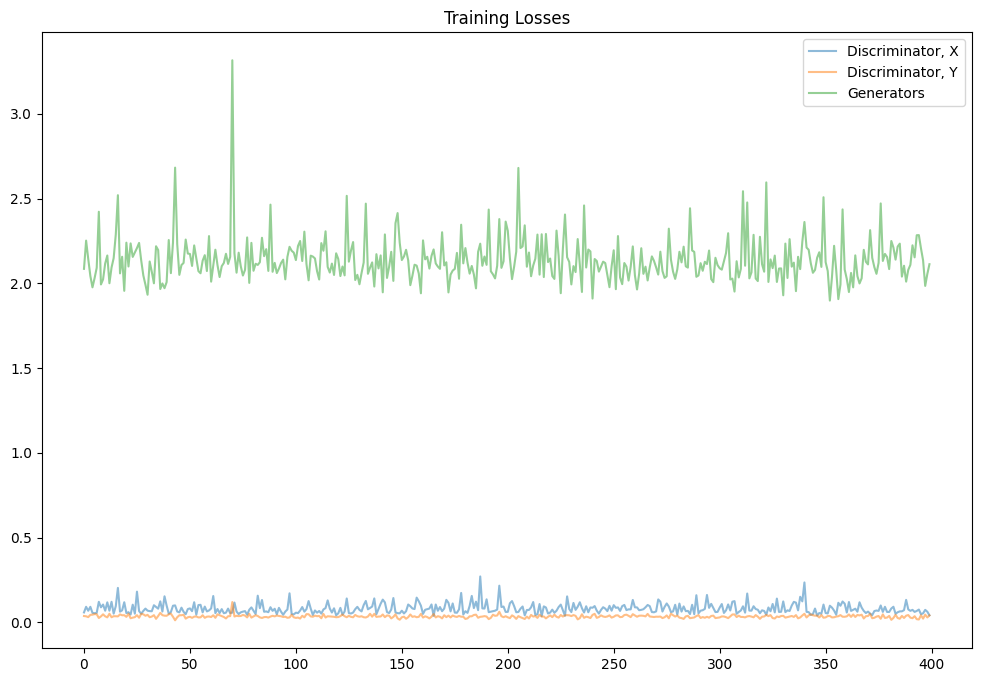

In [23]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)

plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!


In [24]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


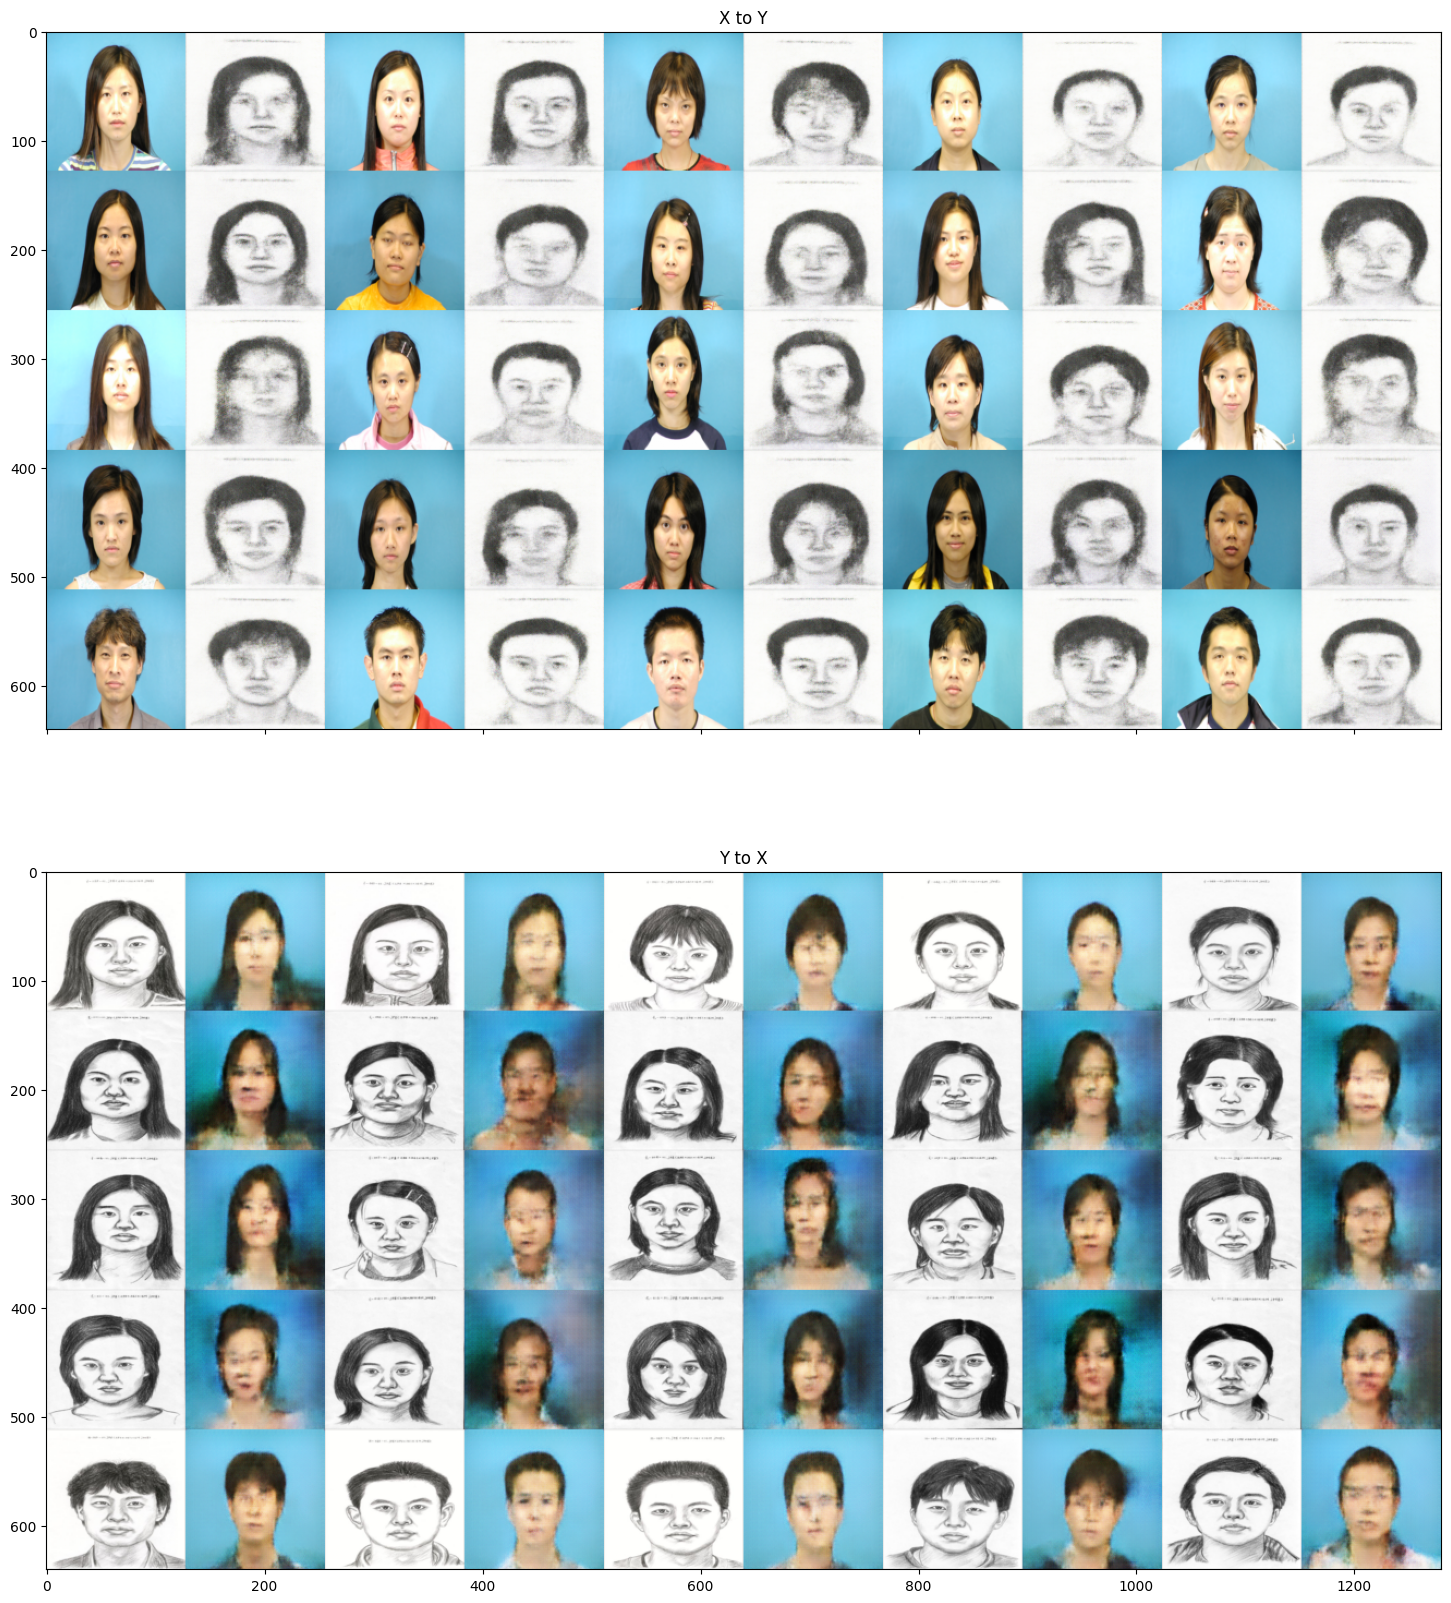

In [25]:
# view samples at iteration 100
view_samples(100, 'samples_cyclegan')

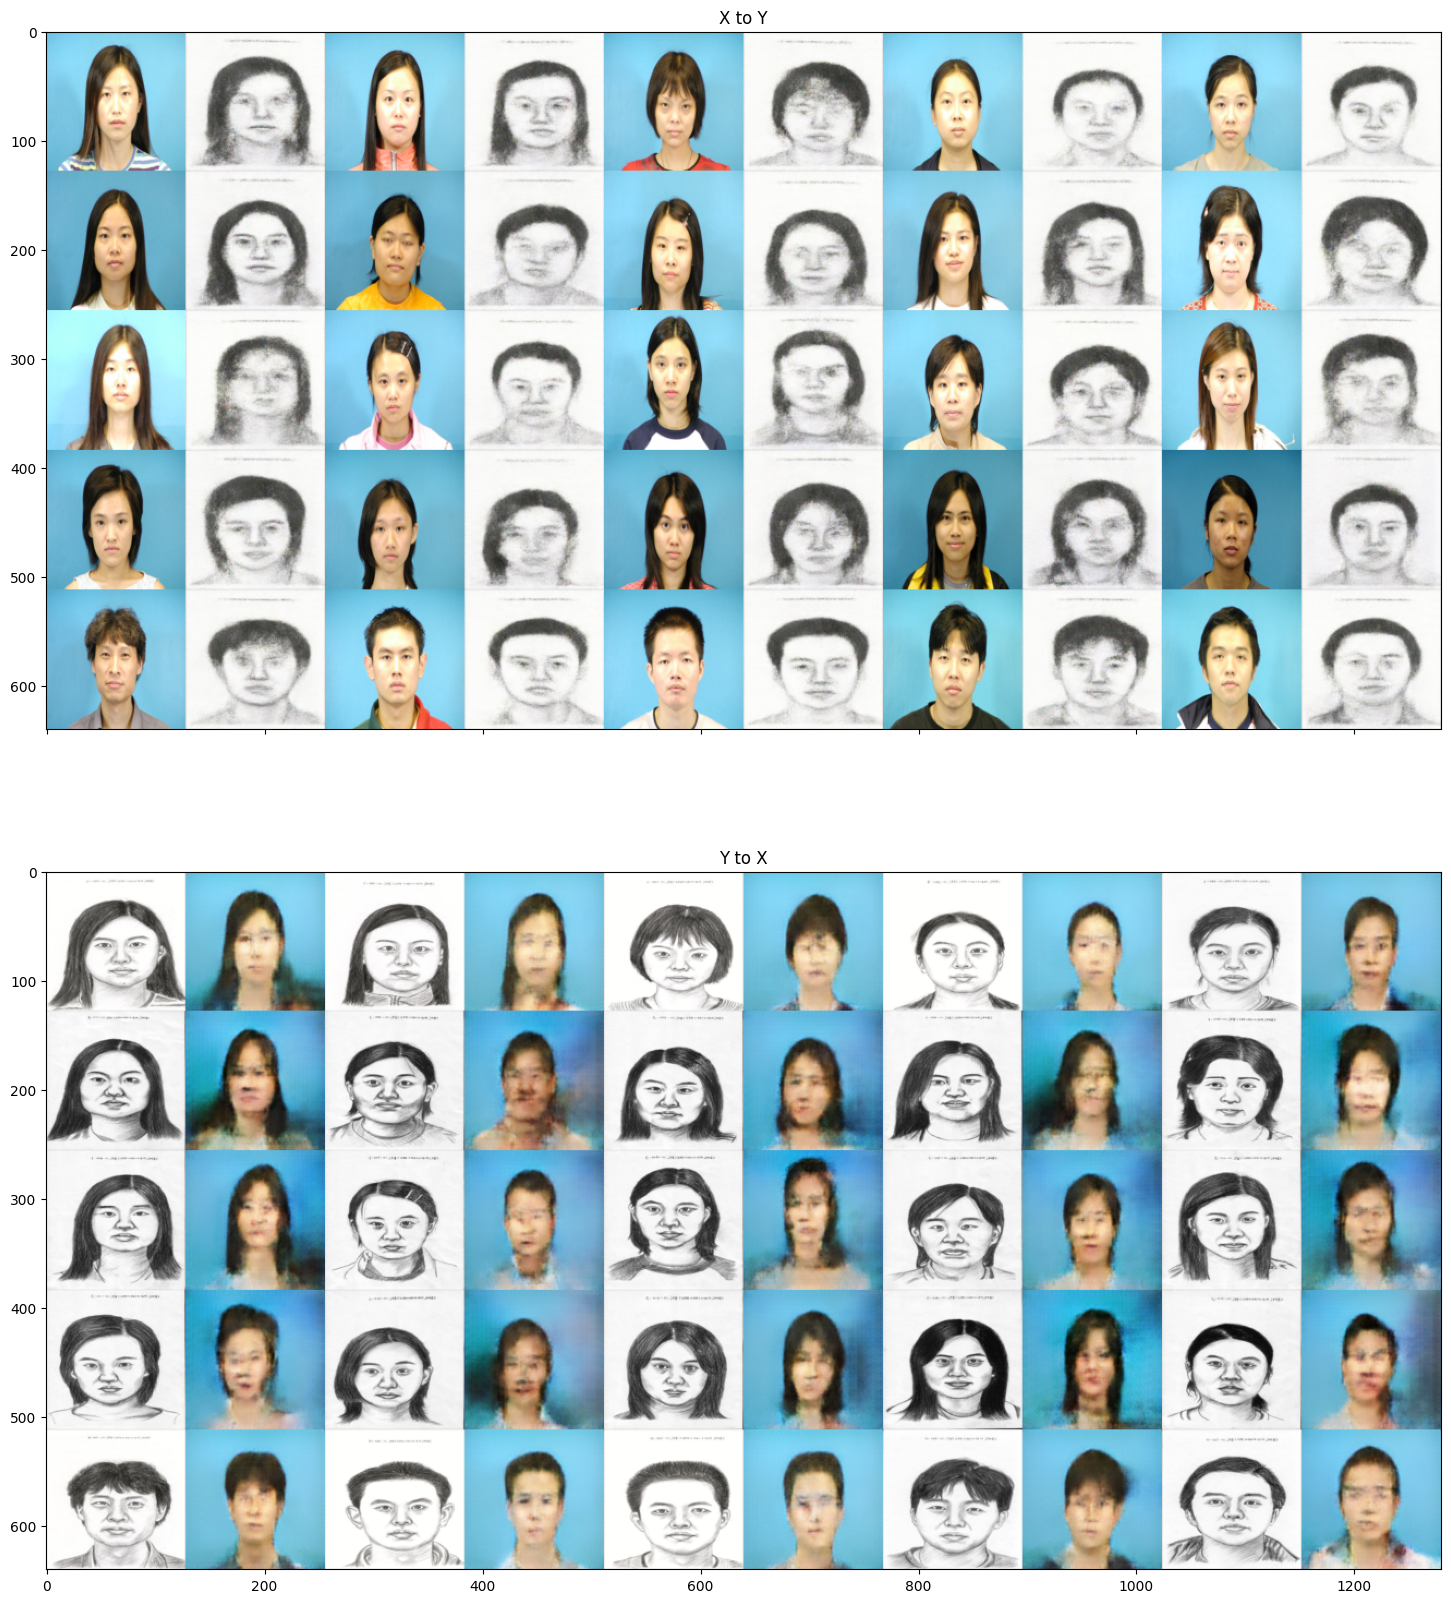

In [26]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')

In [31]:
import os
import glob
from google.colab import files
import shutil

# to be compatible with BSRGAN

!rm -r input
!rm -r test_results
upload_folder = 'input'
result_folder = 'test_results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving m-041-01.jpg to m-041-01.jpg
move m-041-01.jpg to input/m-041-01.jpg


In [35]:
import sys, os
sys.path.append(os.path.abspath(".."))
%run MainProgram.ipynb --mode infer

AttributeError: ignored

AttributeError: ignored

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%cd /content/URSCT-SESR

file = os.listdir(result_folder)
img = Image.open(os.path.join(result_folder, file[0]))

plt.imshow(img)
# Raw, Ours' Results